In [1]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [2]:
class DQN(tf.keras.Model):
    def __init__(self, num_actions: int, num_hidden_units: int):
        super().__init__()
        self.common1 = layers.Dense(128, activation="relu")
        self.common2 = layers.Dense(64, activation="relu")
        self.common3 = layers.Dense(32, activation="relu")
        self.actor = layers.Dense(num_actions)

    def call(self, inputs: tf.Tensor):
        x = self.common1(inputs)
        x = self.common2(x)
        x = self.common3(x)
        return self.actor(x)
    

In [3]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128
model = DQN(num_actions, num_hidden_units)

In [4]:
def env_step(action) :

    state, reward, done, _ = env.step(action)
    return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          done)


def tf_env_step(action):
    return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.bool])

In [5]:
import math
def run_episode(initial_state: tf.Tensor,  model: tf.keras.Model, max_steps: int, gamma):

    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    returns = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state

    for t in tf.range(max_steps):
        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)
        Qvalue = model(state)
        action = tf.random.categorical(Qvalue, 1)[0, 0]
        if np.random.rand() <= 1:
            action = np.random.randint(2)
            
#         action = tf.math.argmax(Qvalue,axis=1)[0]
 
        Qvalue = tf.reduce_max(Qvalue, axis=1)
        values = values.write(t, Qvalue)
 
        # Apply action to the environment to get next state and reward
        state, reward, done = tf_env_step(action)
        reward = tf.cast(reward, dtype=tf.float32)
        next_value = reward
        next_state = tf.expand_dims(state, 0)

        state.set_shape(initial_state_shape)
   
        if not done:
#             print("done----asddd-----------", done)
            next_Qvalue = model(next_state)
            tmp_data = tf.reduce_max(next_Qvalue, axis=1)
            next_value = reward +  gamma*tmp_data
            next_value =  next_value[0]
 
        returns =returns.write(t, next_value)
        # Store reward
        rewards = rewards.write(t, reward)
        if tf.cast(done, tf.bool):
            break

    values = values.stack()
    rewards = rewards.stack()
    returns = returns.stack()
    return values, rewards, returns

In [6]:
### test
initial_state = tf.constant(env.reset(), dtype=tf.float32)
values, rewards, returns = run_episode(initial_state, model, max_steps=2, gamma=0.99)
returns

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0337136, 1.002829 ], dtype=float32)>

In [7]:
# huber_loss = tf.keras.losses.mse()

def compute_loss(values: tf.Tensor, returns: tf.Tensor):
    critic_loss = tf.keras.losses.mse(values, returns)

    return critic_loss

### 4. Defining the training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This tutorial uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

The `tf.function` context is applied to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


# @tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int)  :

 
    with tf.GradientTape() as tape:
        # Run the model for one episode to collect training data
        values, rewards, returns = run_episode(
            initial_state, model, max_steps_per_episode, gamma= 0.99)
    
        # Calculate expected returns
#         returns = get_expected_return(rewards, gamma)

        # Convert training data to appropriate TF tensor shapes
        values, returns = [
            tf.expand_dims(x, 1) for x in [ values, returns]] 

        # Calculating loss values to update our network
        loss = compute_loss(values, returns)

        # Compute the gradients from the loss
        grads = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients to the model's parameters
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         print("------------reward？-------------", rewards)

        episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [9]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(train_step(
            initial_state, model, optimizer, gamma, max_steps_per_episode))
        episodes_reward.append(episode_reward)
        running_reward = statistics.mean(episodes_reward)
#         env.render()
        t.set_description(f'Episode {i}')
        t.set_postfix(
            episode_reward=episode_reward, running_reward=running_reward)

        # Show average episode reward every 10 episodes
        if i % 10 == 0:
            pass # print(f'Episode {i}: average reward: {avg_reward}')

        if running_reward > reward_threshold and i >= min_episodes_criterion:  
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 9999: 100%|█| 10000/10000 [36:26<00:00,  4.57it/s, episode_reward=26, r


Solved at episode 9999: average reward: 22.85!
Wall time: 36min 26s


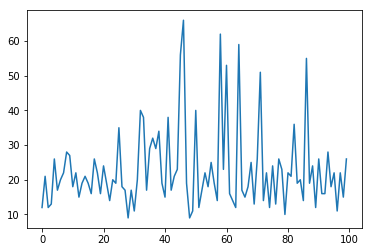

In [10]:
plt.plot(episodes_reward)